## Use to statistically analyze the predictions generated from GPT.
### First load the libaray and read data into dataframe

python=3.12.9

conda activate AI_property

conda install -c conda-forge ace_tools

In [28]:
# import the necessary packages
import os
import numpy as np
import pandas as pd
import boto3
import time
import sys
from openai import OpenAI
import read_data
import GPT_model
import matplotlib.pyplot as plt

cwd = os.getcwd()
print(cwd)

'''
    The default sample file has 2000 samples.
    Named data_all_n2000.xlsx
'''
n = 2000
excel_path = f'./results/data_all_n{n}.xlsx'
df_merged = pd.read_excel(excel_path)
print(f'The length of dataset is {len(df_merged)}')
df_merged.head()

/home/sagemaker-user/HO_AI_Property_Attribute_2025
The length of dataset is 2000


,address,city,state,zip5,zip4,unit_number,county,fault_code,status_code,delivery_bc,qpid,rundt,Number_of_Baths,Number_of_Bedrooms,predicted_bathroom,predicted_bedroom,tokens_used,time_seconds
0,340 HOBART AVE,ABSECON,NJ,8201.0,1127,NaN,ATLANTIC,NaN,S80000,82011127404,84770770,202410,2.0,3,2.0,3.0,88.0,1.17
1,244 PENNSYLVANIA AVE,ABSECON,NJ,8201.0,1219,NaN,ATLANTIC,NaN,S80000,82011219448,84770874,202410,2.0,3,1.0,3.0,90.0,0.72
2,319 E WYOMING AVE,ABSECON,NJ,8201.0,1711,NaN,ATLANTIC,NaN,S80000,82011711199,84770989,202410,4.0,4,2.0,3.0,89.0,0.62
3,312 SPRUCE ST,ABSECON,NJ,8201.0,1726,NaN,ATLANTIC,NaN,S80000,82011726120,84771105,202410,2.0,4,2.0,4.0,86.0,0.69
4,905 TRAYMORE PKWY,ABSECON,NJ,8201.0,1513,NaN,ATLANTIC,NaN,S80000,82011513054,84771453,202410,1.1,2,2.0,3.0,88.0,0.81


### GPT gives the consisitent answer for different queries.
We will compare the ./results/data_all_n1000.xlsx and the first 1000 data in ./results/data_all_n2000.xlsx to see whether GPT gives the same answer for different queries.

1: Load the first 1000 rows from the 2000-sample result Excel file (run 1)\
2: Load all rows from the 1000-sample result Excel file (run 2) \
3: Merge the two DataFrames on 'qpid' to compare predictions\
4: Compare predicted bathroom and bedroom values between the two runs\
5: Print the first 5 mismatched entries for inspection\
6: Print mismatch statistics


In [29]:
n = 2000
excel_path = f'./results/data_all_n{n}.xlsx'
df_2000 = pd.read_excel(excel_path).iloc[:1000]
n = 1000
excel_path = f'./results/data_all_n{n}.xlsx'
df_1000 = pd.read_excel(excel_path)

df_merge = pd.merge(
    df_1000,
    df_2000,
    on='qpid',
    suffixes=('_1000', '_2000'),
)
print(f'After merging on qpid there are {len(df_merge)} data.')

keywords = ['bathroom', 'bedroom']
results = []
for keyword in keywords:
    diff = df_merge[ df_merge['predicted_'+keyword+'_1000'] != df_merge['predicted_'+keyword+'_2000'] ].copy()
    diff[keyword+'_diff'] = df_merge['predicted_'+keyword+'_1000'] - df_merge['predicted_'+keyword+'_2000']
    results.append(diff)

print(results[0][['predicted_bathroom_1000','predicted_bedroom_1000', 'predicted_bathroom_2000','predicted_bedroom_2000']][0:5])
print(f'There are {len(results[0])} predicted bathroom data are not the same, it is {len(results[0])/1000*100:.2f}%.')
print(f'There are {len(results[1])} predicted bedroom data are not the same, it is {len(results[1])/1000*100:.2f}%.')

After merging on qpid there are 1000 data.
    predicted_bathroom_1000  predicted_bedroom_1000  predicted_bathroom_2000  \
1                       2.0                       4                      1.0   
5                       2.0                       3                      1.0   
7                       1.0                       3                      2.0   
12                      1.0                       3                      2.0   
22                      1.0                       3                      2.0   

    predicted_bedroom_2000  
1                      3.0  
5                      3.0  
7                      3.0  
12                     3.0  
22                     5.0  
There are 321 predicted bathroom data are not the same, it is 32.10%.
There are 245 predicted bedroom data are not the same, it is 24.50%.


Bathroom: 961 out of 999 (96.20%) predictions differ by ≤ 1 between runs.


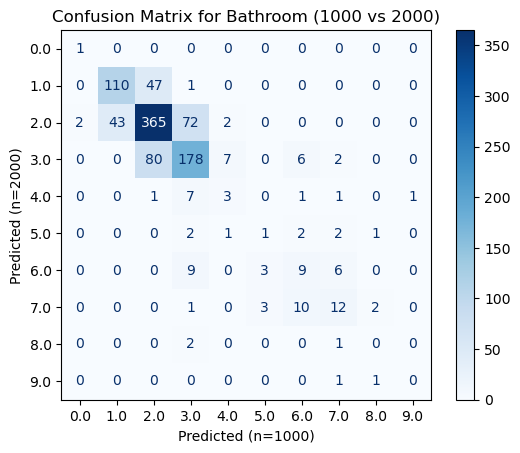

Bedroom: 983 out of 1000 (98.30%) predictions differ by ≤ 1 between runs.


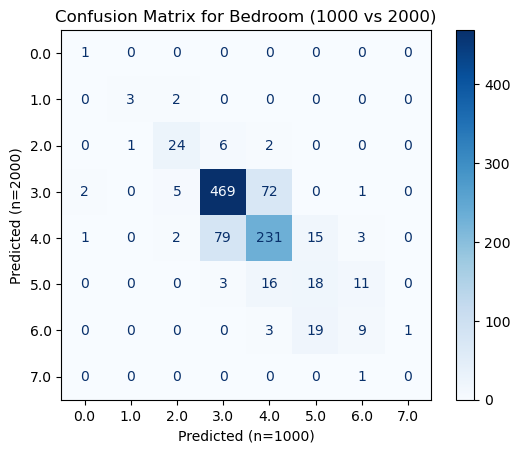

In [30]:
# obtain the confusion matrix for the above code 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

keywords = ['bathroom', 'bedroom']

for keyword in keywords:
    col_1000 = 'predicted_' + keyword + '_1000'
    col_2000 = 'predicted_' + keyword + '_2000'
    
    # Drop rows with NaNs in either prediction
    valid_df = df_merge[[col_1000, col_2000]].dropna()
  
    y_true = valid_df[col_2000]
    y_pred = valid_df[col_1000]
    
    # Get sorted label set (union of true and predicted values)
    labels = sorted(set(y_true.unique()) | set(y_pred.unique()))
    
    diff = (valid_df[col_1000] - valid_df[col_2000]).abs()

    within_1 = (diff <= 1).sum()
    total = len(diff)
    percent_within_1 = within_1 / total * 100

    print(f'{keyword.capitalize()}: {within_1} out of {total} ({percent_within_1:.2f}%) predictions differ by ≤ 1 between runs.')
    
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {keyword.capitalize()} (1000 vs 2000)')
    plt.xlabel('Predicted (n=1000)')
    plt.ylabel('Predicted (n=2000)')
    plt.grid(False)
    plt.show()

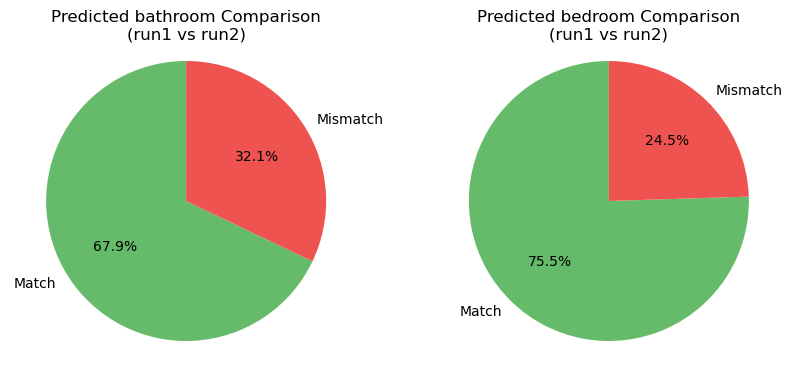

In [31]:
import matplotlib.pyplot as plt

# Count matched and mismatched
keywords = ['bathroom', 'bedroom']
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, keyword in enumerate(keywords):

    matched = 1000 - len(results[i])
    mismatched = len(results[i])

    # Labels and values
    labels = ['Match', 'Mismatch']
    sizes = [matched, mismatched]

    # Plot
    ax = axes[i]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66bb6a', '#ef5350'])
    ax.set_title('Predicted ' + keyword+ ' Comparison\n(run1 vs run2)')
    ax.axis('equal')  # Make the pie circular
plt.show()

### Calculate the distribution for the first 1000 and second 1000 data
Use the histogram to do that.\
See the distributions of them, judge whether consistent.

1: Load the merged prediction dataset with 2000 samples\
2: Split the dataset into first and second halves\
3: Create a 2x2 subplot layout for histograms\
4: Plot histograms of predicted bathroom counts\
5: Plot histograms of predicted bedroom counts


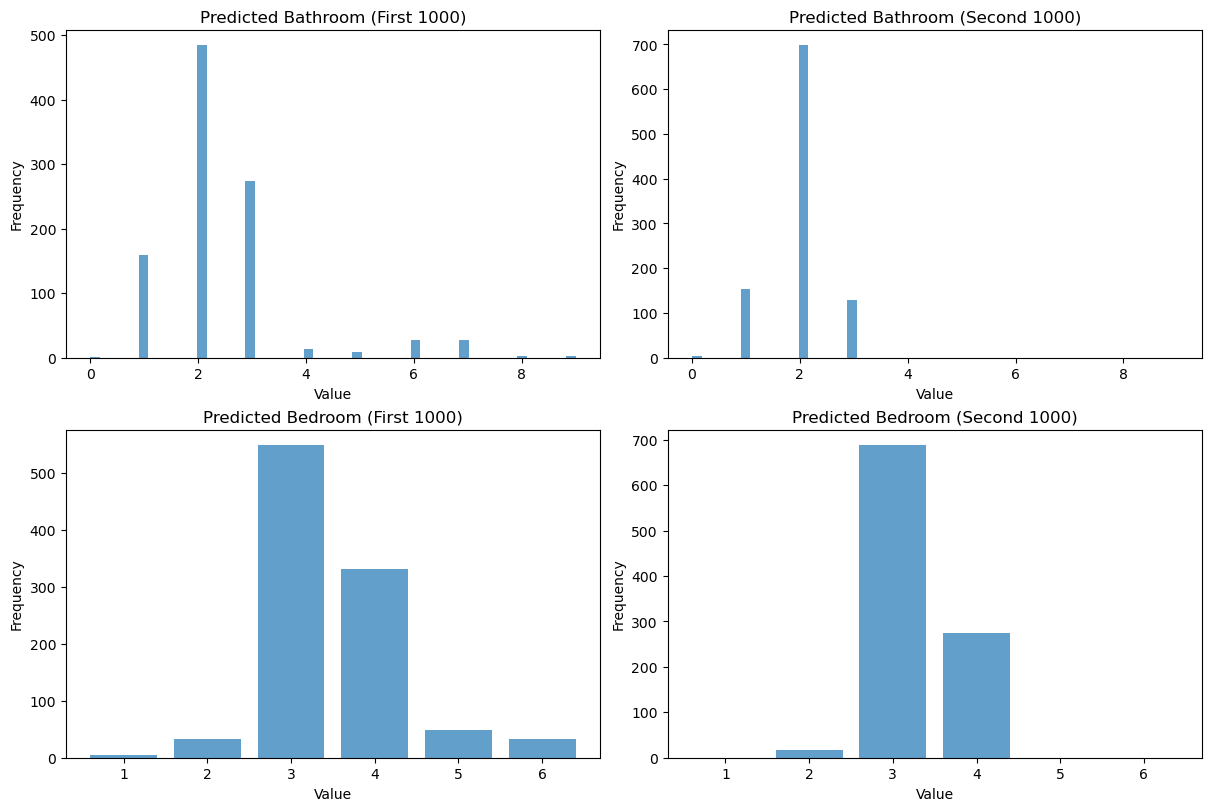

In [32]:
# Split the dataset
n = 2000
excel_path = f'./results/data_all_n{n}.xlsx'
df_merged = pd.read_excel(excel_path)

first_1000 = df_merged.iloc[:1000]
second_1000 = df_merged.iloc[1000:2000]

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Bathroom predictions
axes[0, 0].hist(first_1000['predicted_bathroom'], bins=50, alpha=0.7)
axes[0, 0].set_title('Predicted Bathroom (First 1000)')
axes[0, 1].hist(second_1000['predicted_bathroom'],  range=[0,9], bins=50, alpha=0.7)
axes[0, 1].set_title('Predicted Bathroom (Second 1000)')

# Bedroom predictions
axes[1, 0].hist(first_1000['predicted_bedroom'], bins=range(1, 8), align='left', rwidth=0.8, alpha=0.7)
axes[1, 0].set_title('Predicted Bedroom (First 1000)')
axes[1, 1].hist(second_1000['predicted_bedroom'], bins=range(1, 8), align='left', rwidth=0.8, alpha=0.7)
axes[1, 1].set_title('Predicted Bedroom (Second 1000)')

# Label all axes
for ax in axes.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

Now we want to plot the above figures into Excel.\

1: Replace NaNs with 0 in second_1000 predictions to ensure clean histogram bins\
2: Generate histogram counts for predicted bathrooms\
3: Generate histogram counts for predicted bedrooms\
4: Combine histogram results into two DataFrames\
5: Write histogram data and charts to an Excel file\
6: Define helper function to add column charts in Excel\
7: Add bathroom prediction charts to Excel\
8: Add bedroom prediction charts to Excel


In [33]:
# The final step is to plot the above figure in the Excel based plots
second_1000['predicted_bathroom'].fillna(0, inplace=True)
second_1000['predicted_bedroom'].fillna(0, inplace=True)


# Bathroom prediction histograms
bathroom_bins = list(range(0, 10))  # range [0,9]
bathroom_first = first_1000['predicted_bathroom'].round().astype(int).value_counts().reindex(bathroom_bins, fill_value=0)
bathroom_second = second_1000['predicted_bathroom'].round().astype(int).value_counts().reindex(bathroom_bins, fill_value=0)

# Bedroom prediction histograms
bedroom_bins = list(range(1, 8))  # bins = 1 to 7
bedroom_first = first_1000['predicted_bedroom'].value_counts().reindex(bedroom_bins, fill_value=0)
bedroom_second = second_1000['predicted_bedroom'].value_counts().reindex(bedroom_bins, fill_value=0)

# --- Step 3: Create Combined DataFrame ---
hist_df = pd.DataFrame({
    'Bathroom Bin': bathroom_bins,
    'Bathroom First 1000': bathroom_first.values,
    'Bathroom Second 1000': bathroom_second.values
})
bedroom_df = pd.DataFrame({
    'Bedroom Bin': bedroom_bins,
    'Bedroom First 1000': bedroom_first.values,
    'Bedroom Second 1000': bedroom_second.values
})

# --- Step 4: Write to Excel and Add Charts ---
output_path = './histogram/2000data.xlsx'
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    hist_df.to_excel(writer, sheet_name='Histograms', startrow=0, index=False)
    bedroom_df.to_excel(writer, sheet_name='Histograms', startrow=20, index=False)

    workbook = writer.book
    worksheet = writer.sheets['Histograms']

    # === Helper Function to Add Column Chart ===
    def add_chart(start_row, category_col, value_col, title, position):
        chart = workbook.add_chart({'type': 'column'})
        chart.add_series({
            'name':       '',
            'categories': [worksheet.name, start_row + 1, category_col, start_row + 10, category_col],
            'values':     [worksheet.name, start_row + 1, value_col, start_row + 10, value_col],
        })
        chart.set_title({'name': title, 'name_font': {'size': 14}})
        chart.set_x_axis({'name': 'Value', 'name_font': {'size': 12}, 'num_font': {'size': 10}})
        chart.set_y_axis({'name': 'Frequency', 'name_font': {'size': 12}, 'num_font': {'size': 10}})
        worksheet.insert_chart(position, chart)

    # === Bathroom Charts ===
    add_chart(start_row=0, category_col=0, value_col=1, title='Predicted Bathroom \n(Quantarium available)', position='E2')
    add_chart(start_row=0, category_col=0, value_col=2, title='Predicted Bathroom \n(Quantarium missing)', position='E20')

    # === Bedroom Charts ===
    add_chart(start_row=20, category_col=0, value_col=1, title='Predicted Bedroom \n(Quantarium available)', position='L2')
    add_chart(start_row=20, category_col=0, value_col=2, title='Predicted Bedroom \n(Quantarium missing)', position='L20')

print(f'✅ Excel file saved with 4 editable histograms: {output_path}')

✅ Excel file saved with 4 editable histograms: ./histogram/2000data.xlsx


/tmp/ipykernel_294/1665768856.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  second_1000['predicted_bathroom'].fillna(0, inplace=True)
/tmp/ipykernel_294/1665768856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_1000['predicted_bathroom'].fillna(0, inplace=True)
/tmp/ipykernel_294/1665768856.py:3: FutureWarning: A value is try